In [29]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
import os
import argparse
import pandas as pd
import seaborn as sns

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\rfgla\Documents\Ray\ffmpeg-master-latest-win64-gpl\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
import torch
import pytorch_lightning as pl
from torchvision.io import read_video, read_video_timestamps
import sys
sys.path.append(r'C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master')
from videogpt import download, VQVAE, VideoGPT
from videogpt.data import VideoData
from videogpt.data import preprocess
from convolutional_classifier import Classifier as ConvolutionalClassifier
from matplotlib.colors import LinearSegmentedColormap

In [4]:
# Create arg parser
vqvae_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master\lightning_logs\version_23\checkpoints\epoch=60-step=188489.ckpt"
data_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\data\gesture_sorted_data_incorrect"
config = {
        "--batch_size": 1,
        "--vqvae": vqvae_path,
        "--kernel_size": 3,
        "--out_channels": 3,
        "--n_classes": 8,
        "--lr": 8e-4,
        "--gpus": 1,
        "--data_path": data_path,
    }

parser = argparse.ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser.add_argument('--data_path', type=str, default='/home/wilson/data/datasets/bair.hdf5')
parser.add_argument('--sequence_length', type=int, default=16)
parser.add_argument('--resolution', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--num_workers', type=int, default=8)
parser = ConvolutionalClassifier.add_model_specific_args(parser)
config_args = []
for key in config.keys():
        config_args.append(key)
        config_args.append(str(config[key]))
args = parser.parse_args(config_args)

In [5]:
# Create data loader
data = VideoData(args)
test_loader = data.test_dataloader()
args.n_classes = data.n_classes

In [6]:
# Load classifier from checkpoint
classifier_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\convolutional_classifier\checkpoint_61.ckpt"
device = torch.device('cuda')
model = ConvolutionalClassifier(args)
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=args.lr)

checkpoint = torch.load(classifier_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.to(device)
model.eval()

Classifier(
  (vqvae): VQVAE(
    (encoder): Encoder(
      (convs): ModuleList(
        (0): SamePadConv3d(
          (conv): Conv3d(3, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (1): SamePadConv3d(
          (conv): Conv3d(240, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
      )
      (conv_last): SamePadConv3d(
        (conv): Conv3d(240, 240, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      )
      (res_stack): Sequential(
        (0): AttentionResidualBlock(
          (block): Sequential(
            (0): BatchNorm3d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): SamePadConv3d(
              (conv): Conv3d(240, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
            )
            (3): BatchNorm3d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): SamePadConv3d(
              (conv): Conv3d(120, 240, kernel_size=(1, 1

In [7]:
def chunks_by_overlap(lst, overlap, n):
    for i in range(0, len(lst) - n + 1, overlap):
        if i + n >= len(lst):
            yield lst[-n:], [len(lst)-n, len(lst)]
        else:
            yield lst[i:i + n], [i, i + n]

In [41]:
# Go through test folder videos
groups = ["EFL", "EFR", "SAL", "SAR", "SFE", "SFL", "SFR", "STL", "STR"]
group_correct = 0
bin_correct = 0
count = 0
group_confusion_matrix = np.zeros([args.n_classes, args.n_classes])
bin_confusion_matrix = np.zeros([2, 2])
FP = [0 for _ in groups]
TP = [0 for _ in groups]
FN = [0 for _ in groups]
total_FP = 0
total_TP = 0
total_FN = 0
corrects = [0 for _ in groups]
all_counts = [0 for _ in groups]
confusion_matrices = [np.zeros((2,2)) for _ in groups]
all_probs = [[] for _ in groups]


for this_group in os.listdir(os.path.join(data_path, 'test')):
    group_path = os.path.join(data_path, 'test', this_group)
    if not os.path.isdir(group_path):
        continue
    gt_label = groups.index(this_group)
    for this_video in os.listdir(group_path):
        if not os.path.splitext(this_video)[1] == '.mp4':
            continue
        correct_label = int(this_video.split("_")[4]) - 1  # 0 for correct, 1 for incorrect
        if correct_label == 2:
            print(this_group, this_video)
            continue
        video_filename = os.path.join(group_path, this_video)
        resolution, sequence_length = model.args.resolution, 16
        pts = read_video_timestamps(video_filename, pts_unit='sec')[0]
        video = read_video(video_filename, pts_unit='sec', start_pts=pts[0])[0]

        overlap_size = 4  # number of frames for clips to overlap
        n_clips = video.shape[0] // sequence_length + 1

        # Get clips of certain overlap
        clips = chunks_by_overlap(video, overlap_size, sequence_length)

        pred_labels = []  # store predicted labels for each clip
        pred_probs = []  # store predicted probabilities in the case of a tie
        for video_clip, bounds in clips:
            video_clip = preprocess(video_clip, resolution, sequence_length).unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = model(video_clip)
                pred_probs.append(predictions)
                pred_labels.append(predictions.argmax(axis=1))

        labels, counts = np.unique(torch.asarray(pred_labels).cpu().numpy(), return_counts=True)
        pred_probs = [i.cpu().numpy() for i in pred_probs]
        best_label = None
        best_count = 0
        for this_label in labels:
            this_count = counts[np.where(labels == this_label)][0]
            take_this_label = False
            if best_label is None:
                take_this_label = True
            else:
                if this_count > best_count:
                    take_this_label = True
                elif this_count == best_count:
                    mean_probs = np.mean(pred_probs, axis=0)[0]
                    if mean_probs[this_label] > mean_probs[best_label]:
                        take_this_label = True
            if take_this_label:
                best_label = this_label
                best_count = this_count

        result = best_label == gt_label
        if result:
            pred_label = 0
            group_correct += 1
        else:
            pred_label = 1

        if pred_label == correct_label:
            bin_correct += 1
            total_TP += 1
            TP[gt_label] += 1
            corrects[gt_label] += 1
        else:
            if pred_label == 1:
                total_FP += 1
                FP[gt_label] += 1
            if pred_label == 0:
                total_FN += 1
                FN[gt_label] += 1
        count += 1
        all_counts[gt_label] += 1
    
        group_confusion_matrix[gt_label][best_label] += 1
        bin_confusion_matrix[correct_label][pred_label] += 1
        confusion_matrices[gt_label][correct_label][pred_label] += 1

        mean_probs = np.mean(pred_probs, axis=0)[0]
        binary_probs = [mean_probs[gt_label], np.sum(mean_probs[:gt_label]) + np.sum(mean_probs[gt_label:])] 
        binary_probs = binary_probs / np.sum(binary_probs)
        print(binary_probs)
        all_probs[gt_label].append(binary_probs)


[0.06001202 0.939988  ]
[0.06029281 0.9397072 ]
[0.01545439 0.9845456 ]
[0.05800805 0.9419919 ]
[0.08078304 0.919217  ]
[0.07328738 0.92671263]
[0.06148423 0.9385157 ]
[0.06606041 0.93393964]
[0.04888597 0.951114  ]
[0.06611128 0.9338887 ]
[0.08639853 0.91360146]
[0.05404413 0.9459559 ]
[0.05711961 0.9428804 ]
[0.01904844 0.9809516 ]
[0.07233562 0.92766434]
[0.1254028  0.87459725]
[0.14770856 0.85229146]
[0.15680377 0.8431962 ]
[0.12962194 0.8703781 ]
[0.09608372 0.9039163 ]
[0.14349908 0.8565009 ]
[0.14431387 0.8556861 ]
[0.15450153 0.8454985 ]
[0.09336044 0.9066395 ]
[0.10393234 0.8960677 ]
[0.16163737 0.8383627 ]
[0.11773469 0.88226527]
[0.11279169 0.8872083 ]
[0.16399013 0.8360099 ]
[0.14895502 0.85104495]
[0.13344583 0.8665542 ]
[0.0800136  0.91998637]
[0.09418349 0.9058165 ]
[0.10143036 0.89856964]
[0.10064809 0.8993519 ]
[0.13011143 0.8698886 ]
[0.03225075 0.9677493 ]
[0.0327286 0.9672714]
[0.07796281 0.9220372 ]
[0.0674244  0.93257564]
[0.0641388  0.93586123]
[0.06830034 0.9316

KeyboardInterrupt: 

In [12]:
group_accuracy = group_correct / count
print("Group classification: ", group_accuracy)
bin_accuracy = bin_correct / count
print("Bin classification: ", bin_accuracy)

total_precision = total_TP / (total_TP + total_FP)
total_recall = total_TP / (total_TP + total_FN)
total_F1 = 2 * (total_precision * total_recall) / (total_precision + total_recall)
print(f"Total F1: {total_F1}")

accuracies = np.array(corrects) / np.array(all_counts)
print(accuracies)
F1s = []
for g, this_group in enumerate(groups):
    this_precision = TP[g] / (TP[g] + FP[g])
    this_recall = TP[g] / (TP[g] + FN[g])
    this_F1 = 2 * (this_precision * this_recall) / (this_precision + this_recall)
    F1s.append(this_F1)
    print(f"{this_group}: {this_F1}")

acc_group_matrix = group_confusion_matrix / np.max(group_confusion_matrix, axis=0)
acc_bin_matrix = bin_confusion_matrix / np.max(bin_confusion_matrix, axis=0)

Group classification:  0.483695652173913
Bin classification:  0.7309782608695652
Total F1: 0.8445839874411303
[0.86885246 0.52941176 0.79166667 0.81666667 0.85714286 0.73837209
 0.63934426 0.64285714 0.77419355]
EFL: 0.9298245614035087
EFR: 0.6923076923076923
SAL: 0.8837209302325583
SAR: 0.8990825688073394
SFE: 0.923076923076923
SFL: 0.8494983277591973
SFR: 0.78
STL: 0.782608695652174
STR: 0.8727272727272727


In [19]:
plt.rcParams['font.size'] = 26
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 26
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['font.family'] = 'arial'
all_pred_probs = np.asarray(all_pred_probs)
print(all_labels)
aucs = []
print(all_pred_probs.shape)
ideal_line = np.linspace(0, 1, 10)
for g, this_group in enumerate(groups):
    class_pred_probs = all_pred_probs[:, g]
    binary_labels = np.where(np.array(all_labels) == g, 1, 0)
    fpr, tpr, thresholds = roc_curve(binary_labels, class_pred_probs)
    aucs.append(roc_auc_score(binary_labels, class_pred_probs))
    fig, ax = plt.subplots(1,1)
    ax.plot(fpr, tpr, lw=3)
    ax.plot(ideal_line, ideal_line, c='r', linestyle='--', lw=3)
    plt.title(this_group)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.savefig(f"roc_curve_{this_group}.pdf")
    plt.tight_layout()
    plt.show()
print(aucs)
print(np.mean(aucs))
print(np.std(aucs))

NameError: name 'all_pred_probs' is not defined

In [35]:
def plot_confusion_matrix(cf_matrix, classes, title=None):
    # Create a confusion matrix plot from the matrix of confusion values
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(12, 7))
    if title is not None:
        plt.title(title)
    cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.Blues(np.arange(255))])
    sns.heatmap(df_cm, annot=True, cmap=cmap0, vmin=0)
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.savefig('output.png')
    # plt.plot(cf_matrix)
    return True

True

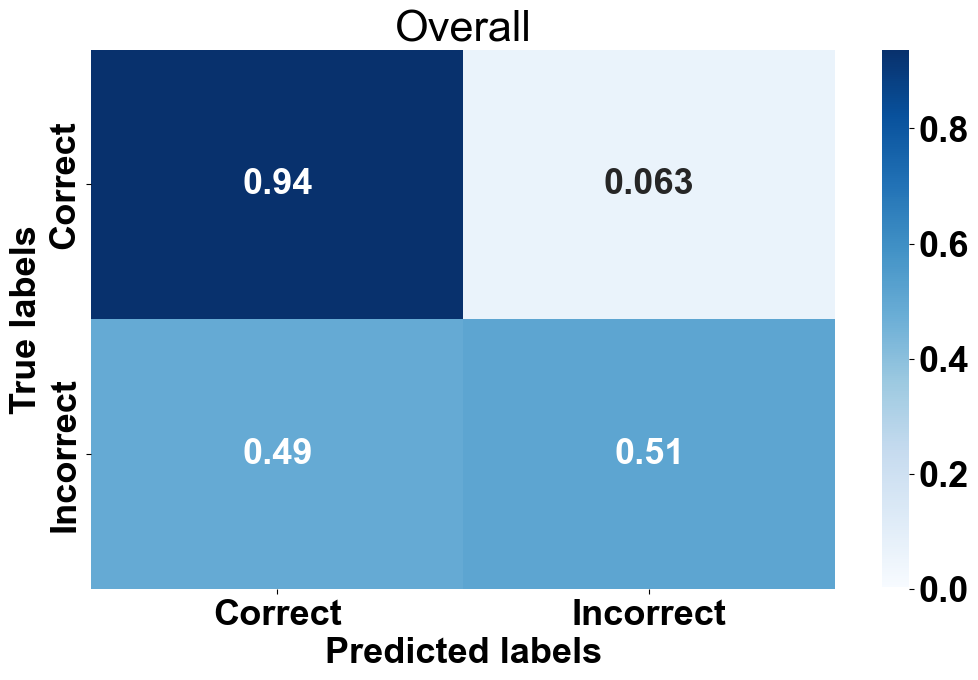

In [39]:
plt.rcParams['font.size'] = 26
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 26
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['font.family'] = 'arial'
b_groups = ["Correct", "Incorrect"]
plot_confusion_matrix(acc_bin_matrix, b_groups, 'Overall')

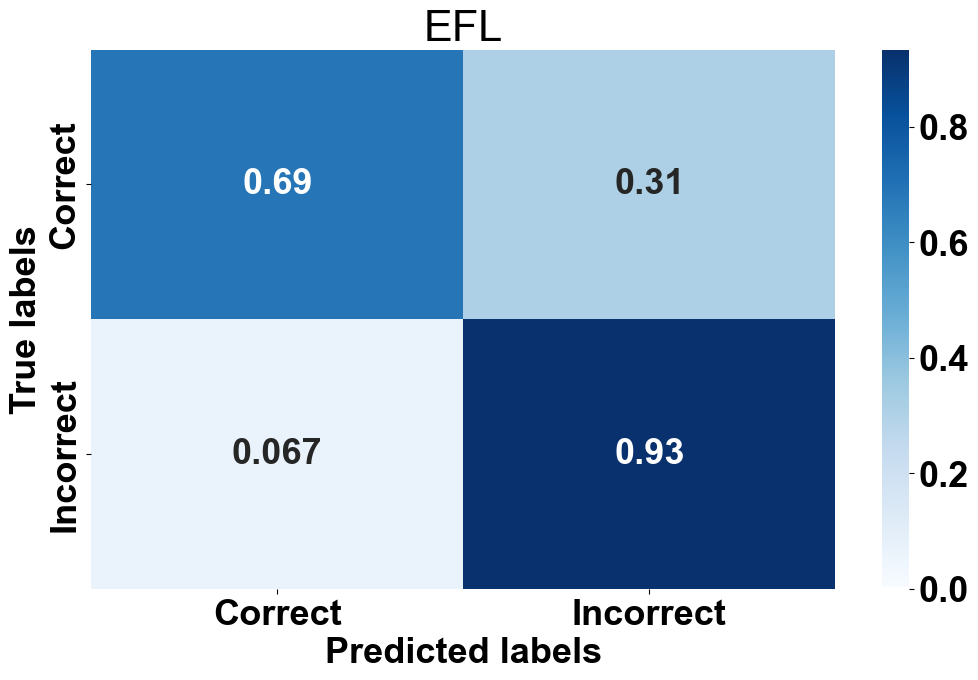

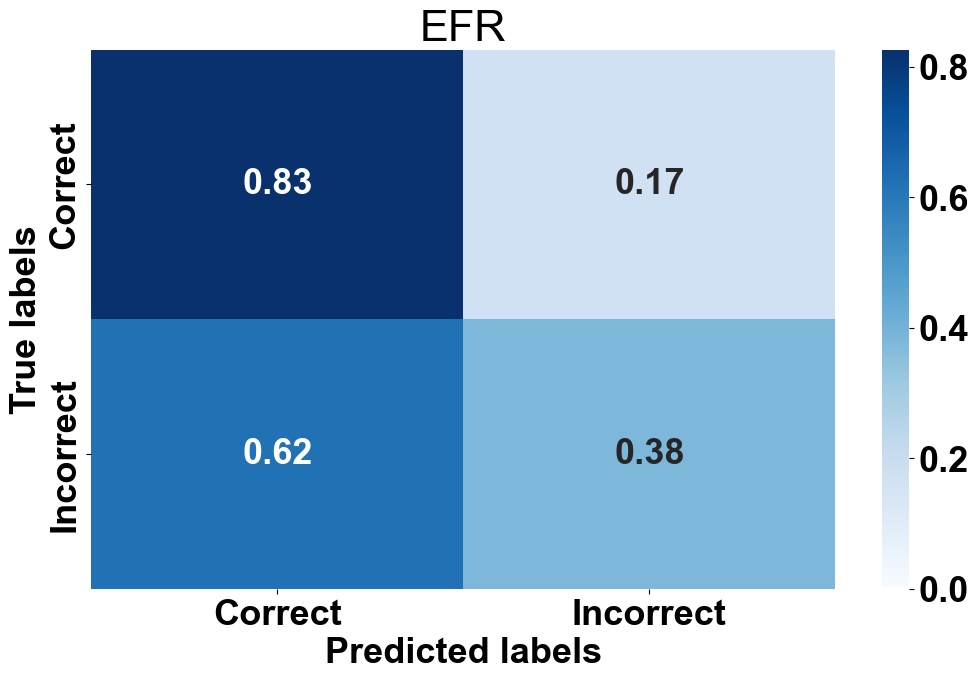

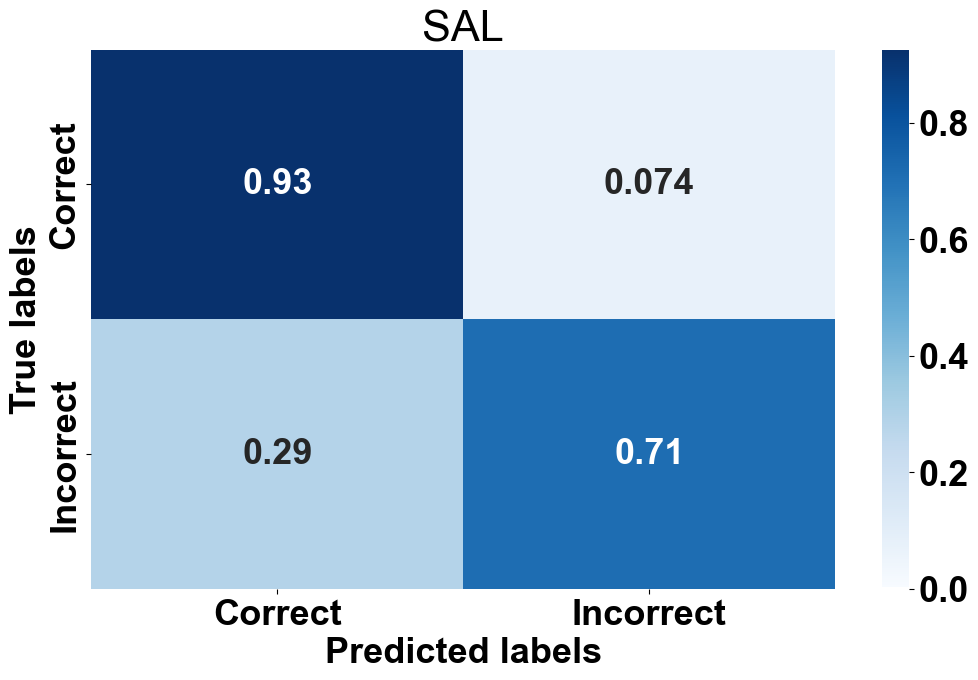

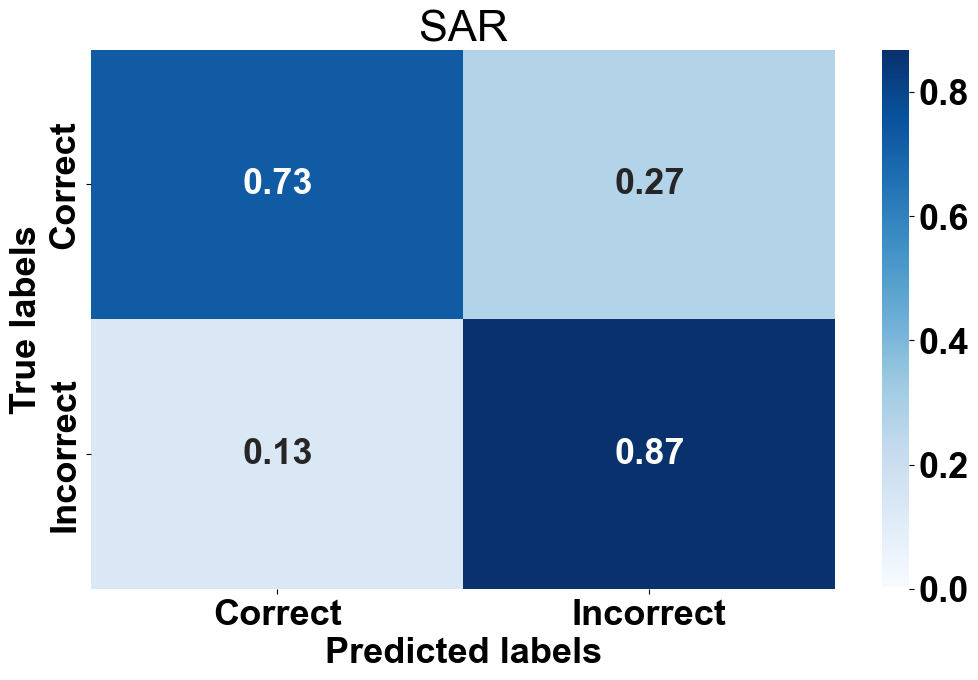

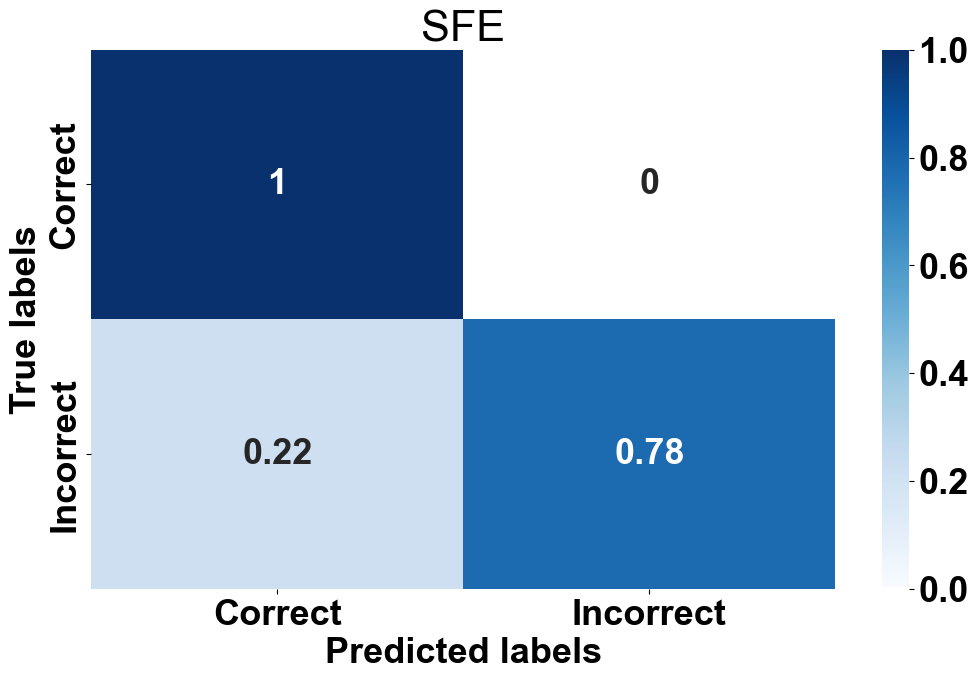

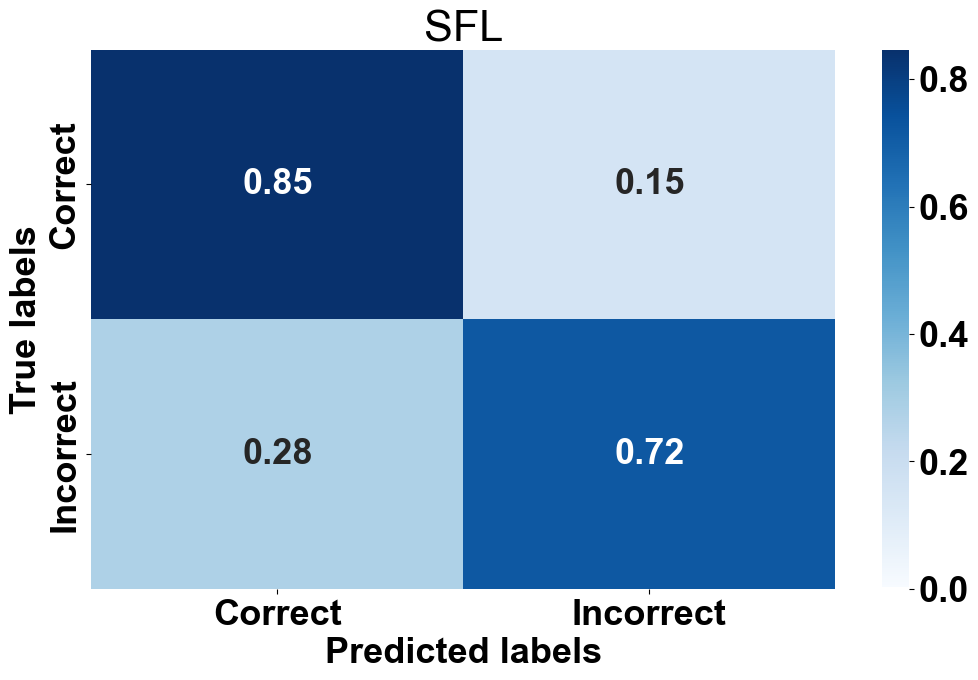

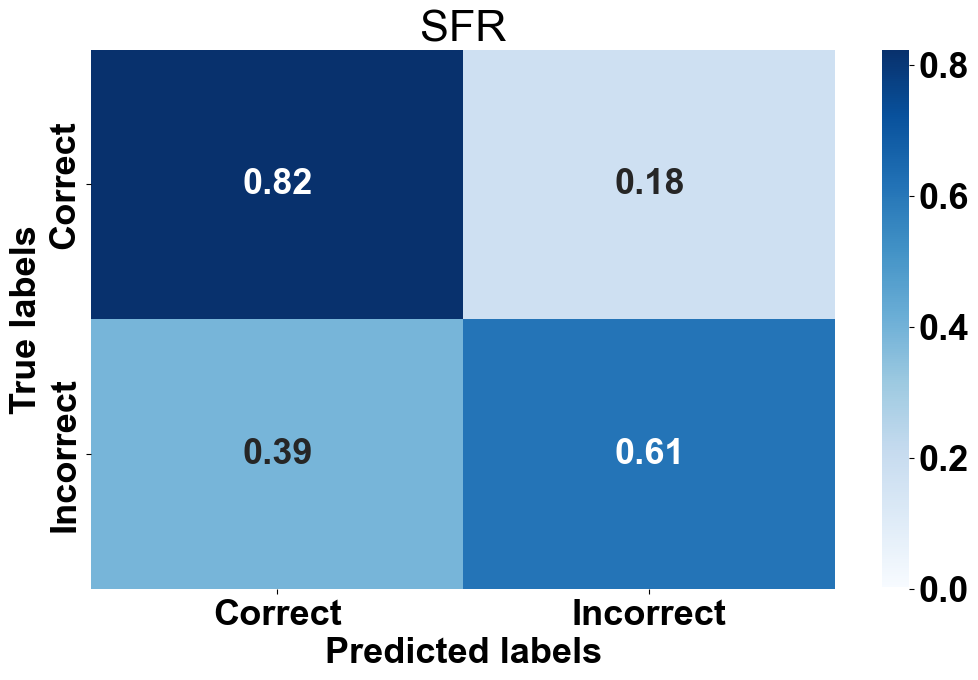

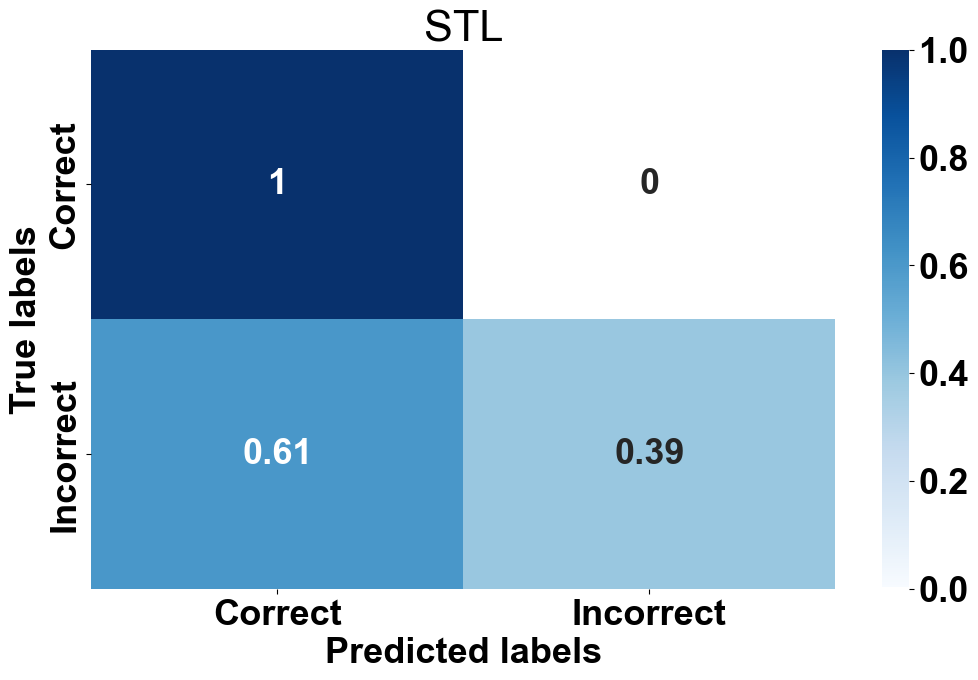

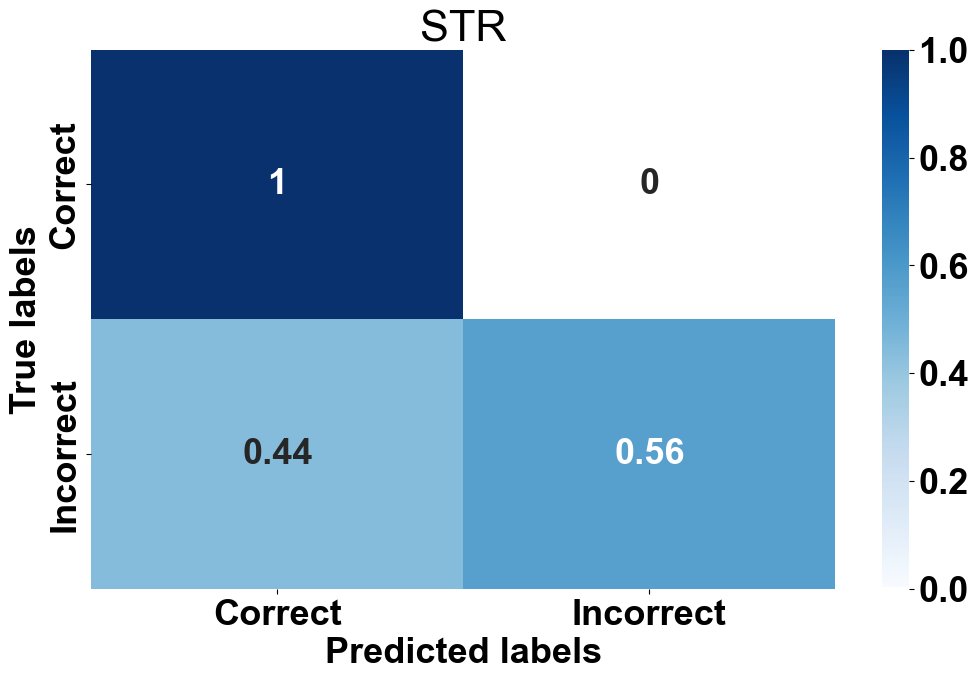

In [38]:
plt.rcParams['font.size'] = 26
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 26
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['font.family'] = 'arial'
for g, this_group in enumerate(groups):
    plot_confusion_matrix(confusion_matrices[g], b_groups, this_group)
    os.rename('output.png', f"binary_confusion_matrix_{this_group}.png")